In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [97]:
# Load the data
nordpool = pd.read_csv('New Data/2021/Nordpool DKK.csv')
energinet = pd.read_csv('New Data/2021/Energinet DKK.csv')
weather_observation = pd.read_csv('New Data/2021/Weather Observation.csv')
weather_forecast = pd.read_csv('New Data/2021/Weather Forecast.csv')
network = pd.read_csv('New Data/2021/Network Manager.csv')

# Filter energinet price area
energinet = energinet[energinet['PriceArea | PriceArea | 804696'] == 'DK2']
# Drop price area
energinet.drop('PriceArea | PriceArea | 804696', axis=1, inplace=True)

# Convert ts to datetime
nordpool['ts'] = pd.to_datetime(nordpool['ts'])
energinet['ts'] = pd.to_datetime(energinet['ts'])
weather_observation['ts'] = pd.to_datetime(weather_observation['ts'])
weather_forecast['ts'] = pd.to_datetime(weather_forecast['ts'])
network['ts'] = pd.to_datetime(network['ts'])

# Resample network_manager data to hourly intervals (average the data)
network = network.set_index('ts')
network = network.resample('H').mean()
network.reset_index(inplace=True)

/var/folders/tz/wvdldxqj00gc2cslzkpx77sr0000gn/T/ipykernel_72819/2096482961.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  network = network.resample('H').mean()


## Step 2: Data Handling

In [98]:
# Compare length of dfs + get first & last timestamp
def get_first_last(**dfs):
    # Initialize
    first_last = pd.DataFrame(index=['first', 'last', 'length', 'start_check', 'end_check'])
    col_name='ts'
    # Save first and last timestamp for each dataframe
    for name, df in dfs.items():
        first_ts = df['ts'].iloc[0]
        last_ts = df['ts'].iloc[-1]
        start_check = start == first_ts
        end_check = end == last_ts
        first_last[name] = [first_ts, last_ts, len(df), start_check, end_check]
    return first_last

# Initialize
start = pd.to_datetime('2021-01-01 00:00:00')
end = pd.to_datetime('2021-12-31 23:00:00')

print("Length of a year in hours:", 365*24)
get_first_last(nordpool=nordpool, energine=energinet, weather_observation=weather_observation, weather_forecast=weather_forecast, network=network)

Length of a year in hours: 8760


,nordpool,energine,weather_observation,weather_forecast,network
first,2021-01-02 00:00:00,2021-01-01 00:00:00,2021-01-15 16:00:00,2021-01-01 00:00:00,2021-01-01 00:00:00
last,2021-12-31 23:00:00,2021-12-31 23:00:00,2021-12-31 23:00:00,2021-12-29 11:00:00,2021-12-31 23:00:00
length,8735,8759,7936,8694,8760
start_check,False,True,False,True,True
end_check,True,True,True,False,True


In [99]:
# Merge the dataframes on network with left join
data = pd.merge(network, weather_forecast, on='ts', how='left')
data = pd.merge(data, weather_observation, on='ts', how='left') 

# Sort the data by the timestamp column 'ts' to ensure time order
data21 = data.sort_values(by='ts')

data21.head()

,ts,Hasle Common 10kV Lines Voltage | has_fel_10kvskinnespend | 804133,Hasle Vind Active Power | has_vin_effekt | 804123,Hasle Vind Current | has_vin_belastning | 804117,Weather forecast for the max air temperature for the coming 6 hours at Bornholm | 9F7P/00/00/MET-Norway/forecast/air_temperature_max | 128206,Weather forecast for wind direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/wind_direction | 128270,Weather forecast for the precipitation amount for the coming 1 hour at Bornholm | 9F7P/00/00/MET-Norway/forecast/precipitation_amount_acc | 128238,Weather forecast for the relativehumidity amount at Bornholm | 9F7P/00/00/MET-Norway/forecast/relative_humidity_2m | 128254,Weather forecast for wind speed at Bornholm | 9F7P/00/00/MET-Norway/forecast/wind_speed | 128286,Weather forecast for wind speed y_direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/y_wind_10m | 128318,...,Weather forecast for wind speed x_direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/x_wind_10m | 128302,Weather forecast for the air temperature at Bornholm | 9F7P/00/00/MET-Norway/forecast/air_temperature_2m | 128190,Observed maximum temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_max_past1h/06193 | 406592,Observed mean intensity of global radiation in the latest hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/radia_glob_past1h/06193 | 406672,Observed minimum temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_min_past1h/06193 | 406608,Observed mean wind speed the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/wind_speed_past1h/06193 | 406640,Observed mean humidity past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/humidity_past1h/06193 | 406576,Observed mean temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_mean_past1h/06193 | 406560,Observed mean wind direction the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/wind_dir_past1h/06193 | 406624,Observed accumulated precipitation the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/precip_past1h/06193 | 406656
0,2021-01-01 00:00:00,10.505372,0.310046,19.138536,275.52020,189.13286,0.000000,0.848557,3.711973,3.658367,...,0.593647,275.51404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 01:00:00,10.499852,0.739963,42.792531,275.50630,191.73468,0.269043,0.937904,3.358219,3.176009,...,0.794102,275.36557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 02:00:00,10.440138,0.877331,50.523536,275.13600,184.39082,0.167969,0.974747,3.255157,3.315285,...,0.328136,275.08374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01 03:00:00,10.423414,0.842384,47.936477,274.88626,178.39856,0.000000,0.973976,3.109769,3.461883,...,-0.328434,274.86594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01 04:00:00,10.401766,0.469178,28.816449,274.93670,170.38286,0.662842,0.989250,3.090981,3.048118,...,-0.469315,274.80240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
# Missing values
data21.isnull().sum()

ts                                                                                                                                                                  0
Hasle Common 10kV Lines Voltage | has_fel_10kvskinnespend | 804133                                                                                                594
Hasle Vind Active Power | has_vin_effekt | 804123                                                                                                                 594
Hasle Vind Current | has_vin_belastning | 804117                                                                                                                  594
Weather forecast for the max air temperature for the coming 6 hours at Bornholm | 9F7P/00/00/MET-Norway/forecast/air_temperature_max | 128206                      66
Weather forecast for wind direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/wind_direction | 128270                                                           66
Weat

Load merged data from 2022:

In [101]:
# Load csv
data22 = pd.read_csv('New Data/2022/Wind Data 22.csv')

# Concatenate the dataframes
data = pd.concat([data21, data22], join='inner', axis=0, ignore_index=True)

# Ensure datetime format
data['ts'] = pd.to_datetime(data['ts'])

Column cleaning

In [102]:

# Use regex to remove everything starting from '|'
data.columns = data.columns.str.replace(r'\|.*', '', regex=True)
nordpool.columns = nordpool.columns.str.replace(r'\|.*', '', regex=True)
energinet.columns = energinet.columns.str.replace(r'\|.*', '', regex=True)

# Use regex to remove everything starting from the word "at"
data.columns = data.columns.str.replace(r'\sat.*', '', regex=True)
data.columns = data.columns.str.replace(r'Hasle', '', regex=True)
data.columns = data.columns.str.replace(r'Vind', 'Wind', regex=True)

# Strip columns
data.columns = data.columns.str.strip()

data.columns

Index(['ts', 'Common 10kV Lines Voltage', 'Wind Active Power', 'Wind Current',
       'Weather forecast for the max air temperature for the coming 6 hours',
       'Weather forecast for wind direction',
       'Weather forecast for the precipitation amount for the coming 1 hour',
       'Weather forecast for the relativehumidity amount',
       'Weather forecast for wind speed',
       'Weather forecast for wind speed y_direction',
       'Weather forecast for solar shortwave flux',
       'Weather forecast for the minimum air temperature for the coming 6 hours',
       'Weather forecast for wind speed x_direction',
       'Weather forecast for the air temperature',
       'Observed maximum temperature past hour',
       'Observed mean intensity of global radiation in the latest hour',
       'Observed minimum temperature past hour',
       'Observed mean wind speed the past hour',
       'Observed mean humidity past hour',
       'Observed mean temperature past hour',
       'Observed

/var/folders/tz/wvdldxqj00gc2cslzkpx77sr0000gn/T/ipykernel_72819/3900608154.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  missing_per_day = data.isnull().resample('M').sum()


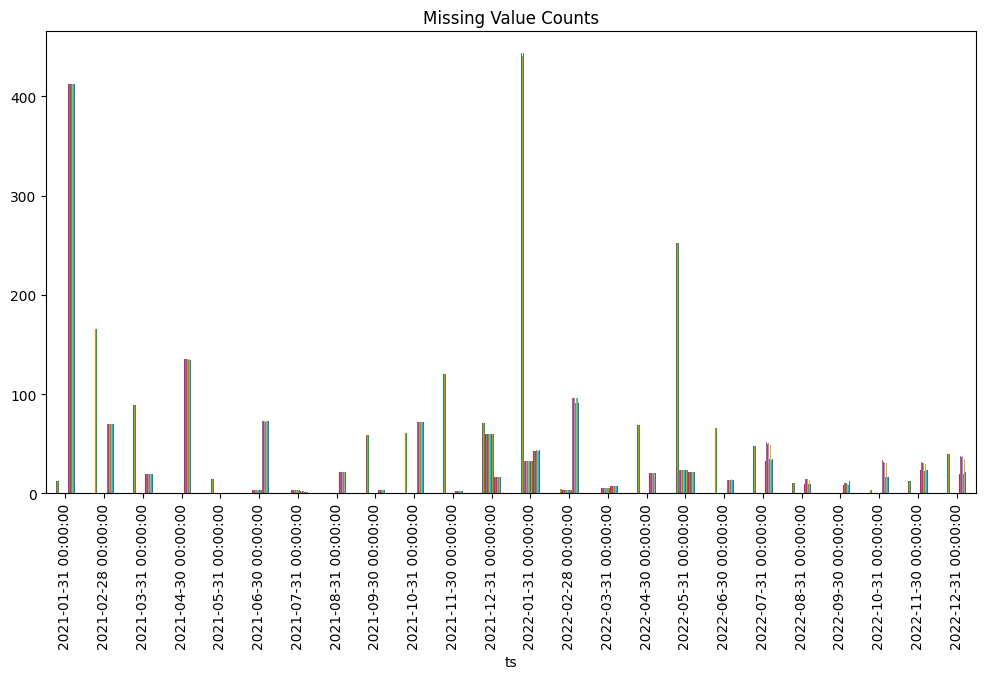

In [103]:
# Resample the data by periods and count missing values
# Set ts as index
data = data.set_index('ts')
missing_per_day = data.isnull().resample('M').sum()
# Reset index
data = data.reset_index()

# Plot
missing_per_day.plot(kind='bar', figsize=(12, 6))
plt.title("Missing Value Counts")
plt.gca().get_legend().remove()
plt.show()

##### Feature Engineering

Lagged days

In [104]:
data = data.rename(columns={'Wind Active Power': 'Wind Power'})

# Shift by 24 hours for daily data
data['Wind Power Lag1'] = data['Wind Power'].shift(24)
data['Wind Power Lag2'] = data['Wind Power'].shift(48)
data['Wind Power Lag3'] = data['Wind Power'].shift(72)

Quantiles from prev week

In [105]:
# Rolling average for 1 week (=168h) for several quantiles
data['Wind Power 0.05 Quantile'] = data['Wind Power'].rolling(window=168).quantile(0.05)
data['Wind Power 0.5 Quantile'] = data['Wind Power'].rolling(window=168).quantile(0.5)
data['Wind Power 0.95 Quantile'] = data['Wind Power'].rolling(window=168).quantile(0.95)

Wind power production is proportional to the cube of the wind speed: $P = \frac{1}{2} \rho \pi r^2 V^3 $


Since 'Observed mean wind speed the past hour' and 'Observed Wind Speed Cubed' are highly correlated, we may encounter multicollinearity which can inflate variance estimates for regression coefficients. -> Lasso or Ridge regression or Nonlinear Regression needed?

In [106]:
# Cube of windspeed
data['Observed Wind Speed Cubed'] = data['Observed mean wind speed the past hour']**3

Cut down the data as weather_observation starts 15/01/2021?

In [108]:
# Exclude all before 15/01/2021 for data
start = pd.to_datetime('2021-01-15 00:00:00')
data = data[data['ts'] >= start]
# Exclude all after 31/12/2021 for data
data = data[data['ts'] <= end]
# Check success
len(data)

8424

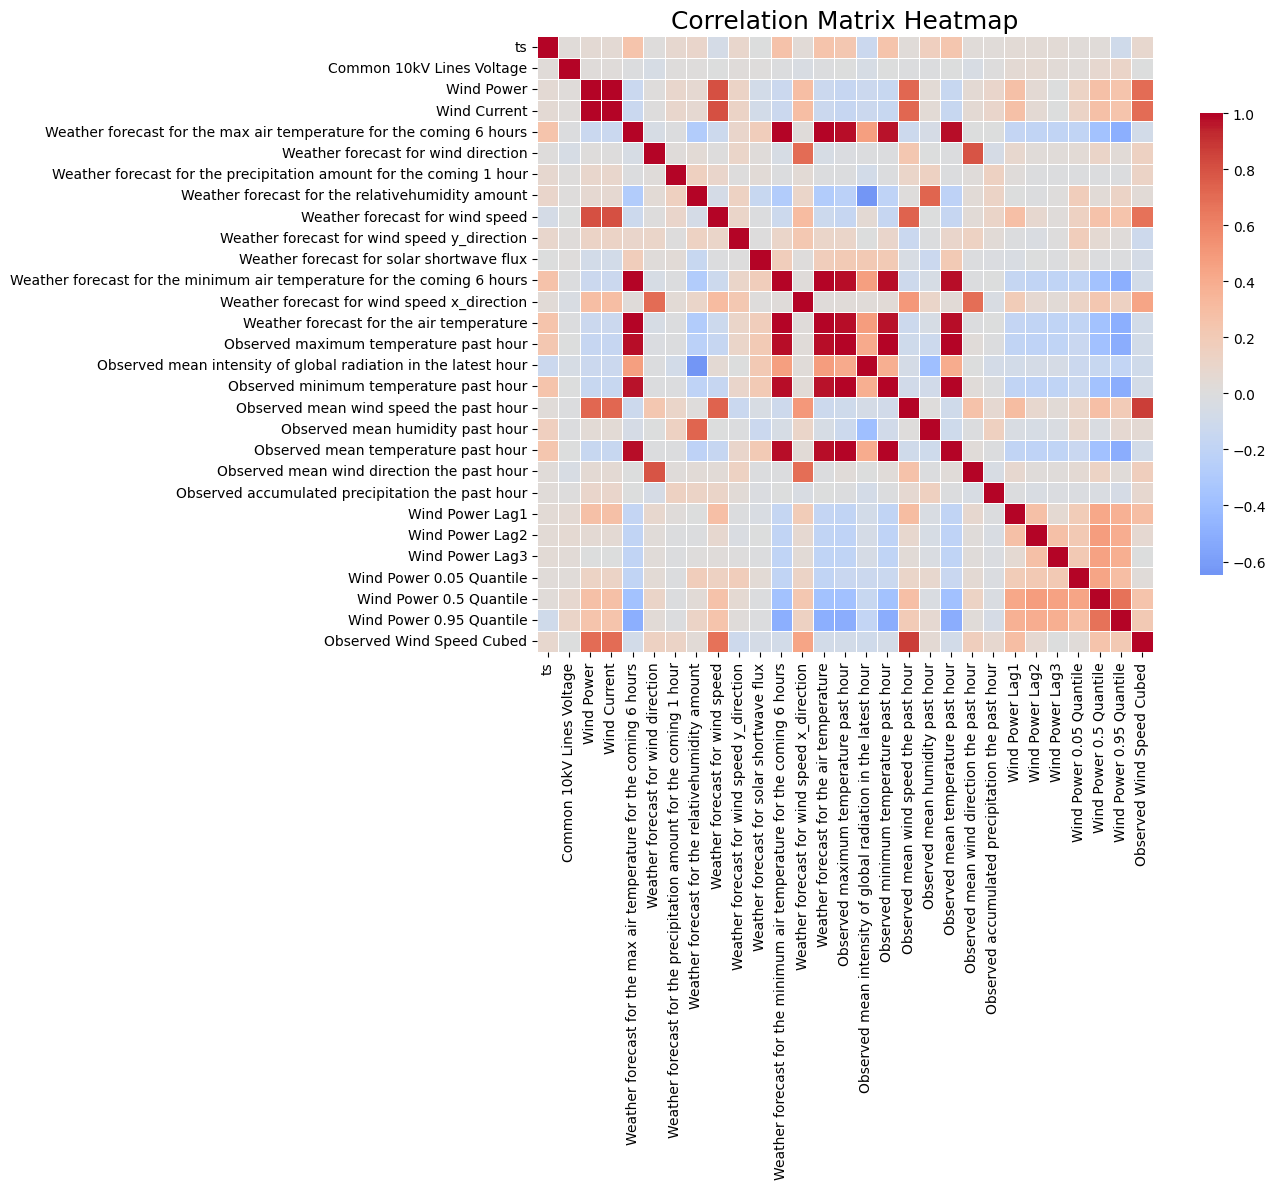

In [109]:
# Correlation matrix between features
corr_matrix = data.corr()
# print(corr_matrix)

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5, 
            cbar_kws={"shrink": 0.75}, square=True)
plt.title('Correlation Matrix Heatmap', fontsize=18)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

## Step 3: Linear Regression

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Get shapes
print("Train set", X_train.shape)
print("Test set", X_test.shape)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)